In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import glob
from collections import namedtuple, OrderedDict
import netCDF4 as nc
import os
import scipy
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools
import gsw
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Ellipse
import matplotlib as mpl

import seaborn as sns
from windrose import plot_windrose
from windrose import WindroseAxes


from dateutil        import parser
from datetime import datetime

sns.set_context('talk')
sns.set_style('darkgrid')

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



nc_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/isopyncal_263/wrong_traj_all_down.nc')
nc_tools.show_variables(nc_file)

odict_keys(['init_x', 'init_y', 'init_z', 'init_t', 'init_age', 'init_transp', 'final_x', 'final_y', 'final_z', 'final_t', 'final_age', 'final_transp', 'traj_lon', 'traj_lat', 'traj_depth', 'traj_time', 'traj_temp', 'traj_salt', 'traj_dens'])


In [3]:


init_x = nc_file.variables['init_x']
init_z = nc_file.variables['init_z']
init_age = nc_file.variables['init_age']

traj_depth = nc_file.variables['traj_depth'][:]
traj_lon   = nc_file.variables['traj_lon'][:]
traj_lat   = nc_file.variables['traj_lat'][:]
traj_rho   = nc_file.variables['traj_dens'][:]
traj_tem   = nc_file.variables['traj_temp'][:]
traj_sal   = nc_file.variables['traj_salt'][:]
traj_time  = nc_file.variables['traj_time']


final_age = nc_file.variables['final_age']


# lon1=nc_file.variables['traj_lon'][:]
# lat1=nc_file.variables['traj_lat'][:]
# dep1=nc_file.variables['traj_depth'][:]
x1=nc_file.variables['init_x'][:]
y1=nc_file.variables['init_y'][:]
t1=nc_file.variables['traj_time'][:]

x2=nc_file.variables['final_x'][:]
y2=nc_file.variables['final_y'][:]


final_z = nc_file.variables['final_z'][:]

final_age_days = final_age[:]/(3600)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [4]:
x_final = []
y_final = []


for i in np.arange(x2.shape[0]):
    x_final = np.append(arr=x_final,values=x_wcvi_slice[np.int(np.rint(x2[i]))-1])
    y_final = np.append(arr=y_final,values=y_wcvi_slice[np.int(np.rint(y2[i]))-1])

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


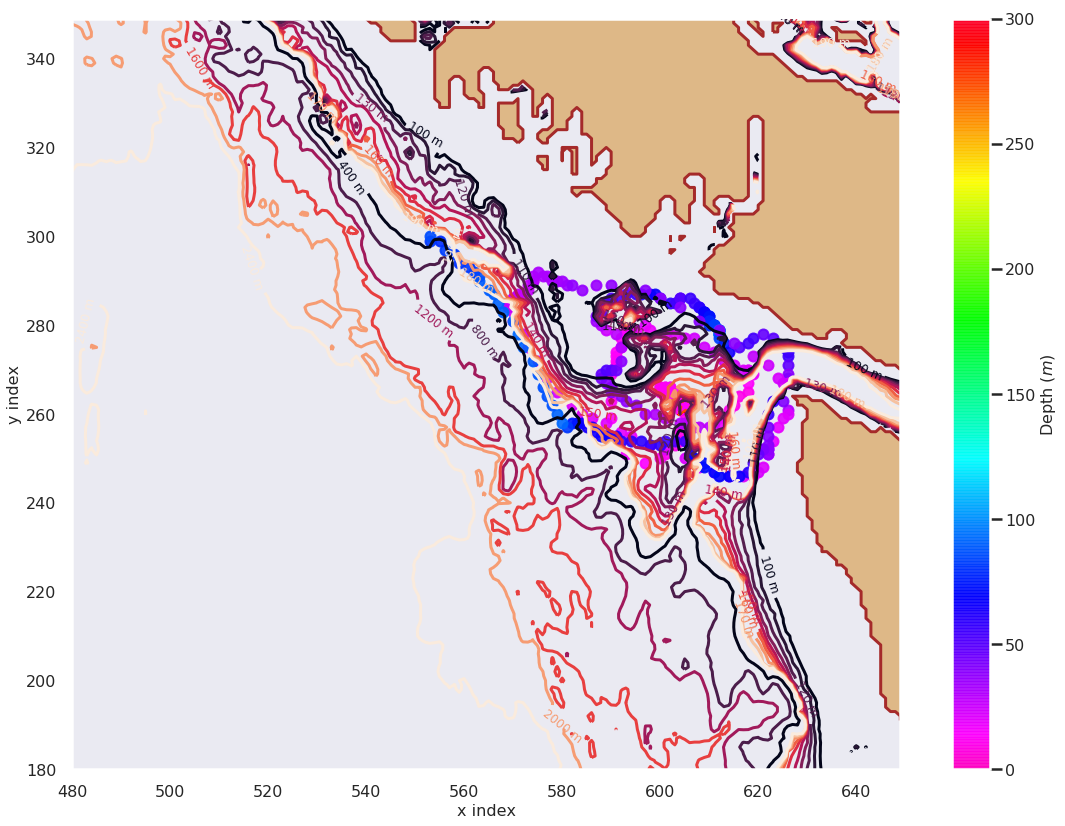

In [29]:
plot_particle_track(particle_ind=3000)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


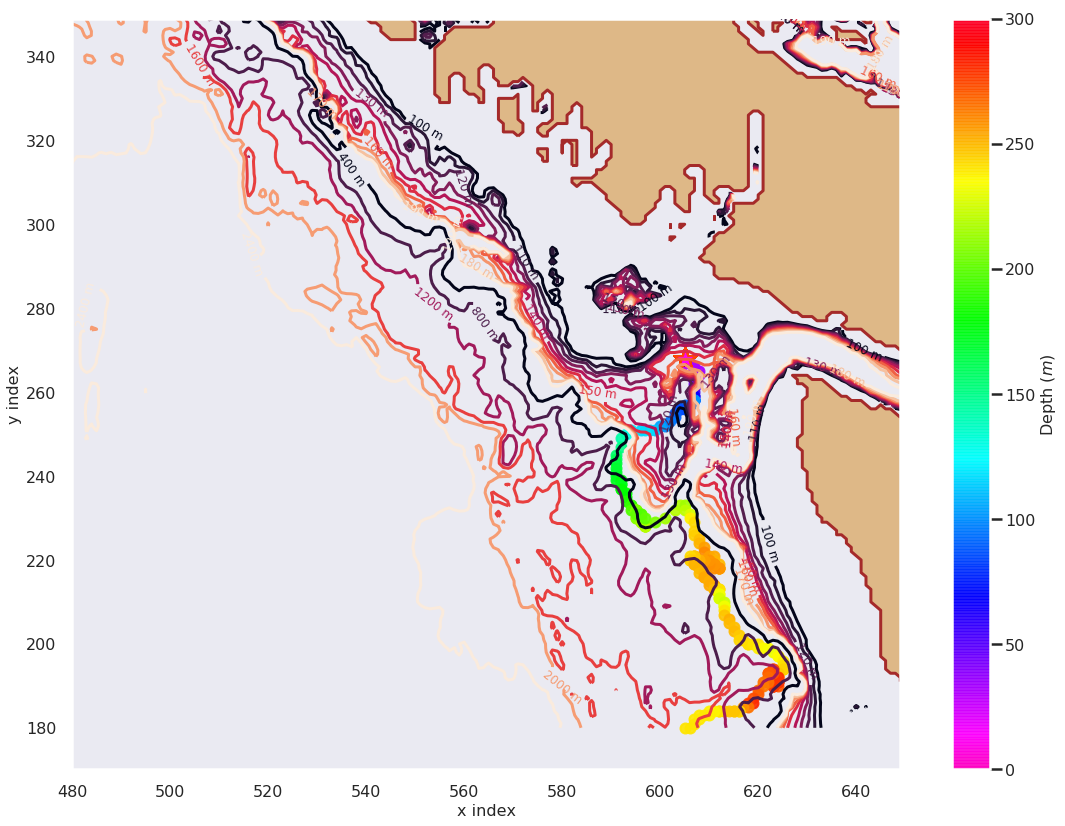

In [30]:
plot_particle_track(particle_ind=1400)

In [5]:
def plot_particle_track(particle_ind):
    
    part = particle_ind
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]



    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon_small = file_model.variables['nav_lon'][1:,1:]
    lat_small = file_model.variables['nav_lat'][1:,1:]




#     cmap=plt.cm.get_cmap('nipy_spectral')
    cmap = plt.cm.get_cmap('gist_rainbow_r')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # part = ind[0]
    # for part in ind[139]:

    for k in np.arange(0,np.int(final_age_days[part]),10):
        y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
        q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

        t = np.int(np.rint(120 - traj_time[k,part]*120))
        level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



        j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                                  lon_small,lat_small,grid='NEMO',tols=\
                                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


    #     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
    # #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    # ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    ax.grid()

    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()
    
    
    
def plot_pie_diagram(off_percentage, south_percentage, cuc_percentage, juan_percentage, north_percentage):

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]




    cmap=plt.cm.get_cmap('nipy_spectral')
    #     cmap = plt.cm.get_cmap('gist_rainbow')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)
    for k in np.arange(x1.shape[0]):
        ax.scatter(x_wcvi_slice[np.int(x1[k]-1)],y_wcvi_slice[np.int(y1[k]-1)], marker = '*', c = 'red', s = 10, linewidths=3)
    

    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    x = [520,575]
    y = [320,200]
    ax.plot(x, y , 'bo-')


    ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
    ax.hlines(y = 320, xmin = 520, xmax=590, color = 'b')
    ax.grid()

    axins = inset_axes(ax, width="50%", height="75%",
                       bbox_to_anchor=(.085, .15, .5, .5),
                       bbox_transform=ax.transAxes, loc=3)
    axins.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    axins.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)


    labels = 'Offshore', 'From South', 'CUC','Strait outflow', 'From North', 'Local water'
    sizes = [off_percentage, south_percentage, cuc_percentage, juan_percentage, north_percentage, \
             100- (off_percentage + south_percentage + cuc_percentage + juan_percentage + north_percentage)]
    explode = (0, 0.1, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')


    size = 0.35
    vals = np.array([[9.5, 0], [10.2, 0], [12.3, 0], [25.4, 51.7-25.4]])

    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(4)*4)
    inner_colors = cmap(np.arange(5)*4)#cmap(np.array([1, 4, 7, 10, 13, 25]))

    axins.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    axins.axis('equal') 
    ax.vlines(x = 648, ymin = 255, ymax = 271, color = 'blue')

    fig.tight_layout()
    
    
def get_cov_ellipse(cov, centre, nstd, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)


def find_index(k):
    
    indice = np.zeros(final_age.shape[0])
    
    for m in np.arange(traj_lon.shape[1]):

        y, x = geo_tools.find_closest_model_point(traj_lon[k,m],traj_lat[k,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        y1,x1 = geo_tools.find_closest_model_point(traj_lon[k-500,m],traj_lat[k-500,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

        bbox = mpl.transforms.Bbox(points=[(x,y), (x1,y1)]) 

        if (mpl.path.Path(vertices=vert).intersects_bbox(bbox, filled=True)) == True:
            
            indice[m] = m

        else:
            continue

    indexes = np.array(np.nonzero(indice))
    
    return indexes[0]


def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)
    return ax


In [6]:
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

p1= (x[0],y[0])
p1 = np.asarray(p1)
p2 = (x[1], y[1])
p2 = np.asarray(p2)



d = np.empty_like(x_final)

off_ind = []


for r in np.arange(x_final.shape[0]):

    p3 = (x_final[r], y_final[r])
    p3 = np.asarray(p3)
    d[r] =np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
    
    if ((d[r] < 0) & (x_final[r] < 575)):
        off_ind = np.append(arr=off_ind, values=np.int(r))

In [7]:
num_north = np.round(a=final_age[(x_final < 580) & (y_final > 300)].shape[0]/final_z.shape[0], decimals=3)

north_percent = 100*num_north

print(north_percent)

num_cuc = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]>28)[0].shape[0]/final_z.shape[0], decimals = 3)

cuc_percent = 100*num_cuc

print(cuc_percent)

num_south = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]<=28)[0].shape[0]/final_z.shape[0], decimals = 3)

south_percent = 100*num_south

print(south_percent)

### Bigger box
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

num_off = off_ind.shape[0]/final_z.shape[0]
off_percent = np.round(a=100*num_off, decimals=1)

print(off_percent)

num_juan = np.round(a=np.where((x_final > 648))[0].shape[0]/final_z.shape[0], decimals=3)

juan_percent = num_juan*100

print(juan_percent)

15.5
11.2
22.8
12.7
5.2


For particles wrongly predicted by model on 26.3 isopycncal and below


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


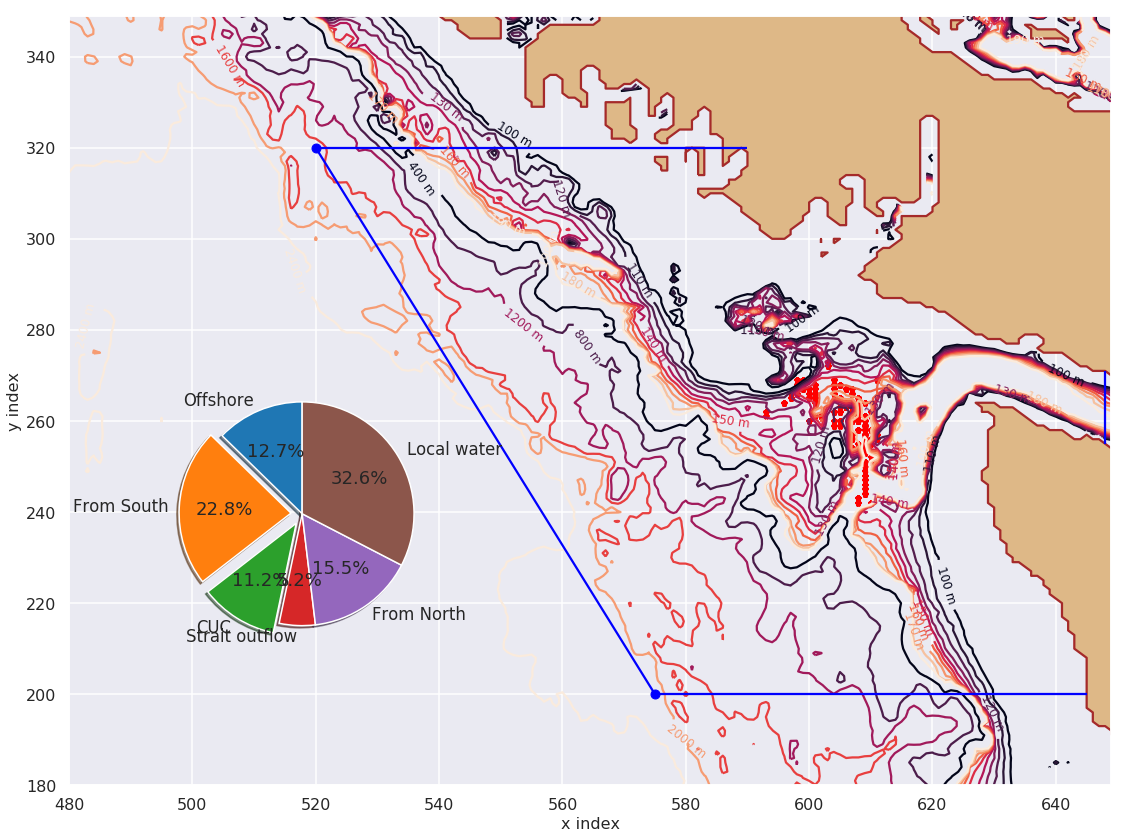

In [8]:
print("For particles wrongly predicted by model on 26.3 isopycncal and below")


plot_pie_diagram(cuc_percentage=cuc_percent, juan_percentage=juan_percent, \
                 north_percentage=north_percent, south_percentage=south_percent, \
                 off_percentage=off_percent)

In [9]:
traj_tem_last   = np.empty_like(final_age_days)
traj_sal_last   = np.empty_like(final_age_days)
traj_rho_last   = np.empty_like(final_age_days)
traj_depth_last = np.empty_like(final_age_days)


traj_tem_init   = np.empty_like(final_age_days)
traj_sal_init   = np.empty_like(final_age_days)
traj_rho_init   = np.empty_like(final_age_days)
traj_depth_init = np.empty_like(final_age_days)

for r in np.arange(traj_tem_last.shape[0]):
    traj_tem_last[r]  =  traj_tem[np.int(final_age_days[r]),r]
    traj_sal_last[r]  =  traj_sal[np.int(final_age_days[r]),r]
    traj_rho_last[r]  =  traj_rho[np.int(final_age_days[r]),r]
    traj_depth_last[r] = traj_depth[np.int(final_age_days[r]),r]
    
    traj_tem_init[r]  =  traj_tem[0,r]
    traj_sal_init[r]  =  traj_sal[0,r]
    traj_rho_init[r]  =  traj_rho[0,r]    
    traj_depth_init[r]=  traj_depth[0,r] 
    

In [10]:
traj_tem_final_cuc = traj_tem_last[(final_z > 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]

traj_sal_final_cuc = traj_sal_last[(final_z > 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]

traj_rho_final_cuc = traj_rho_last[(final_z > 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]


traj_depth_final_cuc = traj_depth_last[(final_z > 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]

traj_days_final_cuc = final_age_days[(final_z > 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]/24

traj_tem_final_cuc = traj_tem_final_cuc[~(traj_tem_final_cuc == 1.0000000200408773e+20)]

traj_sal_final_cuc = traj_sal_final_cuc[~(traj_sal_final_cuc == 1.0000000200408773e+20)]

traj_depth_final_cuc  = traj_depth_final_cuc[~(traj_rho_final_cuc == 1.0000000200408773e+20)]
traj_days_final_cuc   = traj_days_final_cuc[~(traj_rho_final_cuc == 1.0000000200408773e+20)]
traj_rho_final_cuc    = traj_rho_final_cuc[~(traj_rho_final_cuc == 1.0000000200408773e+20)]



traj_tem_final_north = traj_tem_last[((x_final < 580) & (y_final > 320))]
traj_tem_final_north = traj_tem_final_north[~(traj_tem_final_north == 1.0000000200408773e+20)]

traj_sal_final_north = traj_sal_last[((x_final < 580) & (y_final > 320))]
traj_sal_final_north = traj_sal_final_north[~(traj_sal_final_north == 1.0000000200408773e+20)]

traj_rho_final_north = traj_rho_last[((x_final < 580) & (y_final > 320))]
traj_depth_final_north = traj_depth_last[((x_final < 580) & (y_final > 320))]
traj_days_final_north  = final_age_days[((x_final < 580) & (y_final > 320))]/24

traj_depth_final_north  = traj_depth_final_north[~(traj_rho_final_north == 1.0000000200408773e+20)]
traj_days_final_north   = traj_days_final_north[~(traj_rho_final_north == 1.0000000200408773e+20)]
traj_rho_final_north = traj_rho_final_north[~(traj_rho_final_north == 1.0000000200408773e+20)]



traj_tem_final_south = traj_tem_last[(final_z <= 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]

traj_sal_final_south = traj_sal_last[(final_z <= 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]

traj_rho_final_south = traj_rho_last[(final_z <= 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]

traj_depth_final_south = traj_depth_last[(final_z <= 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]
traj_days_final_south  = final_age_days[(final_z <= 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]/24


traj_tem_final_south = traj_tem_final_south[~(traj_tem_final_south == 1.0000000200408773e+20)]

traj_sal_final_south = traj_sal_final_south[~(traj_sal_final_south == 1.0000000200408773e+20)]


traj_depth_final_south = traj_depth_final_south[~(traj_rho_final_south == 1.0000000200408773e+20)]
traj_days_final_south  = traj_days_final_south[~(traj_rho_final_south == 1.0000000200408773e+20)]
traj_rho_final_south = traj_rho_final_south[~(traj_rho_final_south == 1.0000000200408773e+20)]


traj_tem_final_juan = traj_tem_last[(x_final > 648)]
traj_tem_final_juan = traj_tem_final_juan[~(traj_tem_final_juan == 1.0000000200408773e+20)]

traj_sal_final_juan = traj_sal_last[(x_final > 648)]
traj_sal_final_juan = traj_sal_final_juan[~(traj_sal_final_juan == 1.0000000200408773e+20)]

traj_rho_final_juan = traj_rho_last[(x_final > 648)]

traj_depth_final_juan = traj_depth_last[(x_final > 648)]
traj_days_final_juan = final_age_days[(x_final > 648)]/24

traj_depth_final_juan = traj_depth_final_juan[~(traj_rho_final_juan == 1.0000000200408773e+20)]
traj_days_final_juan  = traj_days_final_juan[~(traj_rho_final_juan == 1.0000000200408773e+20)]
traj_rho_final_juan = traj_rho_final_juan[~(traj_rho_final_juan == 1.0000000200408773e+20)]



x = [510,575]
y = [320,200]

coefficients = np.polyfit(x, y, 1)
x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

# num = np.where((y_final[x_final_off] < y_final_off))[0].shape[0] + np.where((x_final<x_final_off[0]) & \
#                                                                       ((y_final > 200)&(y_final<320)))[0].shape[0]

traj_tem_final_off = []
# traj_tem_final_off = np.append(arr=traj_tem_final_off, \
#                                values= traj_tem_last[np.where((y_final[x_final_off] < y_final_off))[0]])
# traj_tem_final_off = np.append(arr=traj_tem_final_off, \
#                                values = traj_tem_last[np.where((x_final<x_final_off[0]) & \
#                                                                ((y_final > 200)&(y_final<320)))[0]])
# traj_tem_final_off = traj_tem_final_off[~(traj_tem_final_off == 1.0000000200408773e+20)]

traj_sal_final_off = []
# traj_sal_final_off = np.append(arr=traj_sal_final_off, \
#                                values= traj_sal_last[np.where((y_final[x_final_off] < y_final_off))[0]])
# traj_sal_final_off = np.append(arr=traj_sal_final_off, \
#                                values = traj_sal_last[np.where((x_final<x_final_off[0]) & \
#                                                                ((y_final > 200)&(y_final<320)))[0]])
# traj_sal_final_off = traj_sal_final_off[~(traj_sal_final_off == 1.0000000200408773e+20)]


traj_rho_final_off = []

# traj_rho_final_off = np.append(arr=traj_rho_final_off, \
#                                values= traj_rho_last[np.where((y_final[x_final_off] < y_final_off))[0]])
# traj_rho_final_off = np.append(arr=traj_rho_final_off, \
#                                values = traj_rho_last[np.where((x_final<x_final_off[0]) & \
#                                                                ((y_final > 200)&(y_final<320)))[0]])


# traj_depth_final_off = []
# traj_depth_final_off = np.append(arr=traj_depth_final_off, \
#                                values= traj_depth_last[np.where((y_final[x_final_off] < y_final_off))[0]])
# traj_depth_final_off = np.append(arr=traj_depth_final_off, \
#                                values = traj_depth_last[np.where((x_final<x_final_off[0]) & \
#                                                                ((y_final > 200)&(y_final<320)))[0]])
traj_depth_final_off = []
traj_days_final_off = []

for l in np.arange(off_ind.shape[0]):

    traj_depth_final_off = np.append(arr=traj_depth_final_off, values=traj_depth_last[np.int(off_ind[l])])
    traj_days_final_off = np.append(arr=traj_days_final_off, values=final_age_days[np.int(off_ind[l])]/24)
    traj_rho_final_off   = np.append(arr=traj_rho_final_off, values=traj_rho_last[np.int(off_ind[l])])
    traj_tem_final_off   = np.append(arr=traj_tem_final_off, values=traj_tem_last[np.int(off_ind[l])])
    traj_sal_final_off   = np.append(arr=traj_sal_final_off, values=traj_sal_last[np.int(off_ind[l])])


traj_depth_final_off = traj_depth_final_off[~(traj_rho_final_off == 1.0000000200408773e+20)]
traj_days_final_off  = traj_days_final_off[~(traj_rho_final_off == 1.0000000200408773e+20)]
traj_rho_final_off = traj_rho_final_off[~(traj_rho_final_off == 1.0000000200408773e+20)]

In [ ]:
pressure_loc_cuc = np.empty_like(traj_depth_final_cuc)
SA_loc_cuc       = np.empty_like(traj_depth_final_cuc)
CT_loc_cuc       = np.empty_like(traj_depth_final_cuc)
spic_loc_cuc     = np.empty_like(traj_depth_final_cuc)



for i in np.arange(traj_depth_final_cuc.shape[0]):
    
    pressure_loc_cuc[i] = gsw.p_from_z(traj_depth_final_cuc[i],np.mean(traj_lat))
    
    SA_loc_cuc[i] = gsw.SA_from_SP(traj_sal_final_cuc[i], pressure_loc_cuc[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_cuc[i] = gsw.CT_from_pt(traj_sal_final_cuc[i], traj_tem_final_cuc[i])
    
    spic_loc_cuc[i] = gsw.spiciness0(SA_loc_cuc[i], CT_loc_cuc[i])
    
pressure_loc_off = np.empty_like(traj_depth_final_off)
SA_loc_off       = np.empty_like(traj_depth_final_off)
CT_loc_off       = np.empty_like(traj_depth_final_off)
spic_loc_off     = np.empty_like(traj_depth_final_off)



for i in np.arange(traj_depth_final_off.shape[0]):
    
    pressure_loc_off[i] = gsw.p_from_z(traj_depth_final_off[i],np.mean(traj_lat))
    
    SA_loc_off[i] = gsw.SA_from_SP(traj_sal_final_off[i], pressure_loc_off[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_off[i] = gsw.CT_from_pt(traj_sal_final_off[i], traj_tem_final_off[i])
    
    spic_loc_off[i] = gsw.spiciness0(SA_loc_off[i], CT_loc_off[i])
    
pressure_loc_south = np.empty_like(traj_depth_final_south)
SA_loc_south       = np.empty_like(traj_depth_final_south)
CT_loc_south       = np.empty_like(traj_depth_final_south)
spic_loc_south     = np.empty_like(traj_depth_final_south)



for i in np.arange(traj_depth_final_south.shape[0]):
    
    pressure_loc_south[i] = gsw.p_from_z(traj_depth_final_south[i],np.mean(traj_lat))
    
    SA_loc_south[i] = gsw.SA_from_SP(traj_sal_final_south[i], pressure_loc_south[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_south[i] = gsw.CT_from_pt(traj_sal_final_south[i], traj_tem_final_south[i])
    
    spic_loc_south[i] = gsw.spiciness0(SA_loc_south[i], CT_loc_south[i])
    
pressure_loc_north= np.empty_like(traj_depth_final_north)
SA_loc_north       = np.empty_like(traj_depth_final_north)
CT_loc_north       = np.empty_like(traj_depth_final_north)
spic_loc_north     = np.empty_like(traj_depth_final_north)



for i in np.arange(traj_depth_final_north.shape[0]):
    
    pressure_loc_north[i] = gsw.p_from_z(traj_depth_final_north[i],np.mean(traj_lat))
    
    SA_loc_north[i] = gsw.SA_from_SP(traj_sal_final_north[i], pressure_loc_north[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_north[i] = gsw.CT_from_pt(traj_sal_final_north[i], traj_tem_final_north[i])
    
    spic_loc_north[i] = gsw.spiciness0(SA_loc_north[i], CT_loc_north[i])
    

pressure_loc_juan= np.empty_like(traj_depth_final_juan)
SA_loc_juan       = np.empty_like(traj_depth_final_juan)
CT_loc_juan       = np.empty_like(traj_depth_final_juan)
spic_loc_juan     = np.empty_like(traj_depth_final_juan)



for i in np.arange(traj_depth_final_juan.shape[0]):
    
    pressure_loc_juan[i] = gsw.p_from_z(traj_depth_final_juan[i],np.mean(traj_lat))
    
    SA_loc_juan[i] = gsw.SA_from_SP(traj_sal_final_juan[i], pressure_loc_juan[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_juan[i] = gsw.CT_from_pt(traj_sal_final_juan[i], traj_tem_final_juan[i])
    
    spic_loc_juan[i] = gsw.spiciness0(SA_loc_juan[i], CT_loc_juan[i])
    

In [ ]:

# traj_tem_init = traj_tem_init[traj_sal_init > 30]
# traj_sal_init = traj_sal_init[traj_sal_init > 30]


pressure_loc_init = np.empty_like(traj_tem_init)
SA_loc_init       = np.empty_like(traj_depth_init)
CT_loc_init       = np.empty_like(traj_depth_init)
spic_loc_init     = np.empty_like(traj_depth_init)



for i in np.arange(traj_depth_init.shape[0]):
    
    pressure_loc_init[i] = gsw.p_from_z(traj_depth_init[i],np.mean(traj_lat))
    
    SA_loc_init[i] = gsw.SA_from_SP(traj_sal_init[i], pressure_loc_init[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_init[i] = gsw.CT_from_pt(traj_sal_init[i], traj_tem_init[i])
    
    spic_loc_init[i] = gsw.spiciness0(SA_loc_init[i], CT_loc_init[i])
    
    
    
    

In [ ]:
sns.set_context('poster')
sns.set_style('dark')

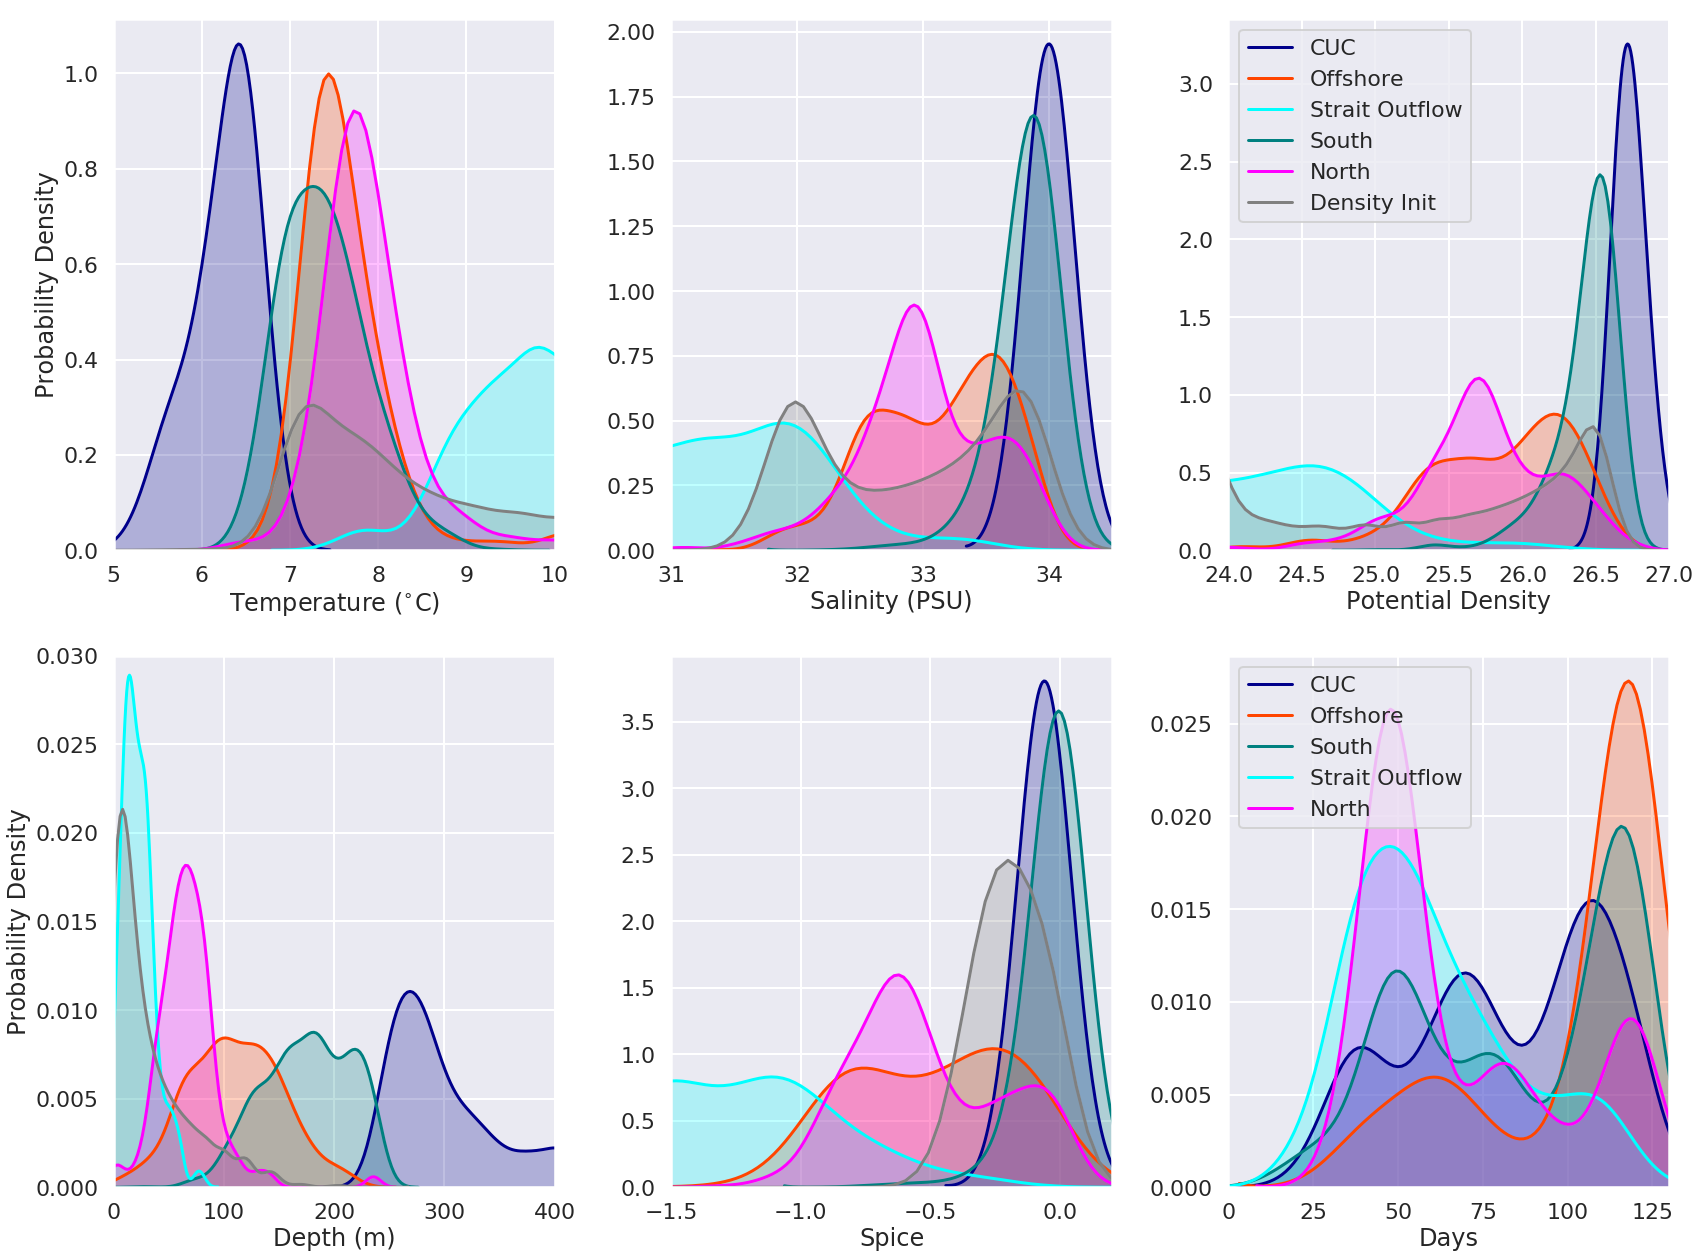

In [ ]:
df = pd.DataFrame()

df['Density CUC']     = traj_rho_final_cuc
df['Temperature CUC'] = traj_tem_final_cuc
df['Salinity CUC']    = traj_sal_final_cuc
df['Spice CUC']       = spic_loc_cuc
df['Depth CUC']       = -traj_depth_final_cuc

dp = pd.DataFrame()

dp['Density OFF']     = traj_rho_final_off
dp['Temperature OFF'] = traj_tem_final_off
dp['Salinity OFF']    = traj_sal_final_off
dp['Spice OFF']       = spic_loc_off
dp['Depth OFF']       = -traj_depth_final_off

dg = pd.DataFrame()

dg['Density South']     = traj_rho_final_south
dg['Temperature South'] = traj_tem_final_south
dg['Salinity South']    = traj_sal_final_south
dg['Spice South']       = spic_loc_south
dg['Depth South']       = -traj_depth_final_south

dh = pd.DataFrame()

dh['Density Juan']     = traj_rho_final_juan
dh['Temperature Juan'] = traj_tem_final_juan
dh['Salinity Juan']    = traj_sal_final_juan
dh['Spice Juan']       = spic_loc_juan
dh['Depth Juan']       = -traj_depth_final_juan


dq = pd.DataFrame()

dq['Density North']     = traj_rho_final_north
dq['Temperature North'] = traj_tem_final_north
dq['Salinity North']    = traj_sal_final_north
dq['Spice North']       = spic_loc_north
dq['Depth North']       = -traj_depth_final_north


da = pd.DataFrame()

da['Density Init']     = traj_rho_init
da['Temperature Init'] = traj_tem_init
da['Salinity Init']    = traj_sal_init
da['Spice Init']       = spic_loc_init
da['Depth Init']       = -traj_depth_init


fig, (ax1,ax2) = plt.subplots(2,3, figsize=(24,18), sharey = False)

q = sns.kdeplot(df['Temperature CUC'], ax = ax1[0],bw=0.2,shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Temperature OFF'], ax = ax1[0], bw=0.25,shade=True, color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Temperature Juan'], ax = ax1[0], bw=0.25, shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Temperature South'], ax = ax1[0], bw=0.2,shade=True, color = 'Teal', label = 'South')

sns.kdeplot(dq['Temperature North'], ax = ax1[0], bw=0.25,shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Temperature Init'], ax = ax1[0], bw = 0.25, shade=True, color = 'Gray', label = None)

ax1[0].set_xlim(5,10)
ax1[0].set_xlabel('Temperature ($^{\circ}$C)')
ax1[0].set_ylabel('Probability Density')
ax1[0].get_legend().remove()
ax1[0].grid()


q = sns.kdeplot(df['Salinity CUC'], ax = ax1[1], bw=0.2,  shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Salinity OFF'], ax = ax1[1],  shade=True,color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Salinity Juan'], ax = ax1[1], shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Salinity South'], ax = ax1[1],  bw=0.2, shade=True, color = 'Teal', label = 'South')

sns.kdeplot(dq['Salinity North'], ax = ax1[1],shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Salinity Init'], ax = ax1[1], bw = 0.2, shade=True, color = 'Gray',label = None)

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 


# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax1[1].set_xlim(31,34.5)
ax1[1].set_xlabel('Salinity (PSU)')
# ax2.set_ylabel('Density')
ax1[1].grid()
# ax1[2].legend()
ax1[1].get_legend().remove()


q = sns.kdeplot(df['Density CUC'], ax = ax1[2], bw=0.1, shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Density OFF'], ax = ax1[2], shade=True,color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Density Juan'], ax = ax1[2], shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Density South'], ax = ax1[2], bw=0.1, shade=True, color = 'Teal', label = 'South')

sns.kdeplot(dq['Density North'], ax = ax1[2], shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Density Init'], ax = ax1[2], bw = 0.1, shade=True, color = 'Gray',label = None)

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 


# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax1[2].set_xlim(24,27)
ax1[2].set_xlabel('Potential Density')
# ax2.set_ylabel('Density')
ax1[2].grid()
ax1[2].legend()
# ax1[2].get_legend().remove()


q = sns.kdeplot(df['Depth CUC'], ax = ax2[0], shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Depth OFF'], ax = ax2[0], shade=True, color = 'orangered', label = 'Offshore')

sns.kdeplot(dg['Depth South'], ax = ax2[0], shade= True, color = 'Teal', label = 'South')

sns.kdeplot(dh['Depth Juan'], ax = ax2[0],  shade=True, color = 'Cyan', label = 'Staright Outflow')

sns.kdeplot(dq['Depth North'], ax = ax2[0],  shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Depth Init'], ax = ax2[0], bw = 8, shade=True, color = 'Gray', label = False)

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 

# lims = [
#     np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
#     np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
# ]


# ax2[0].legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
# ax1.set_xlim(6,14)
ax2[0].set_xlabel('Depth (m)')
ax2[0].set_ylabel('Probability Density')
ax2[0].grid()

ax2[0].set_xlim(0,400)
ax2[0].set_ylim(0,0.03)
ax2[0].get_legend().remove()


q = sns.kdeplot(df['Spice CUC'], ax = ax2[1], bw = 0.1,  shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Spice OFF'], ax = ax2[1], bw = 0.15, shade=True,color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Spice Juan'], ax = ax2[1], bw = 0.15, shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Spice South'], ax = ax2[1],  bw=0.1, shade=True, color = 'Teal', label = 'South')

sns.kdeplot(dq['Spice North'], ax = ax2[1],  shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Spice Init'], ax = ax2[1], bw = 0.1, shade=True, color = 'Gray')

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 


# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax2[1].set_xlim(-1.5,0.2)
ax2[1].set_xlabel('Spice')
# ax2.set_ylabel('Density')
ax2[1].grid()
ax2[1].get_legend().remove()




df = pd.DataFrame()

df['Days CUC']     = traj_days_final_cuc


dp = pd.DataFrame()

dp['Days OFF']     = traj_days_final_off


dg = pd.DataFrame()

dg['Days South']     = traj_days_final_south


dh = pd.DataFrame()

dh['Days Juan']     = traj_days_final_juan

dz = pd.DataFrame()

dz['Days North']    = traj_days_final_north




q = sns.kdeplot(df['Days CUC'], ax = ax2[2],  shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Days OFF'], ax = ax2[2], bw = 10, shade=True, color = 'orangered', label = 'Offshore')

sns.kdeplot(dg['Days South'], ax = ax2[2], shade= True, color = 'Teal', label = 'South')

sns.kdeplot(dh['Days Juan'], ax = ax2[2], shade=True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dz['Days North'], ax = ax2[2],  shade=True, color = 'Magenta', label = 'North')

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 



# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
# ax1.set_xlim(6,14)
ax2[2].set_xlabel('Days')
# ax1.set_ylabel('Probability Density')
ax2[2].grid()
# ax2[2].get_legend().remove()
ax2[2].legend()

ax2[2].set_xlim(0,130)

fig.tight_layout()


(5, 12)

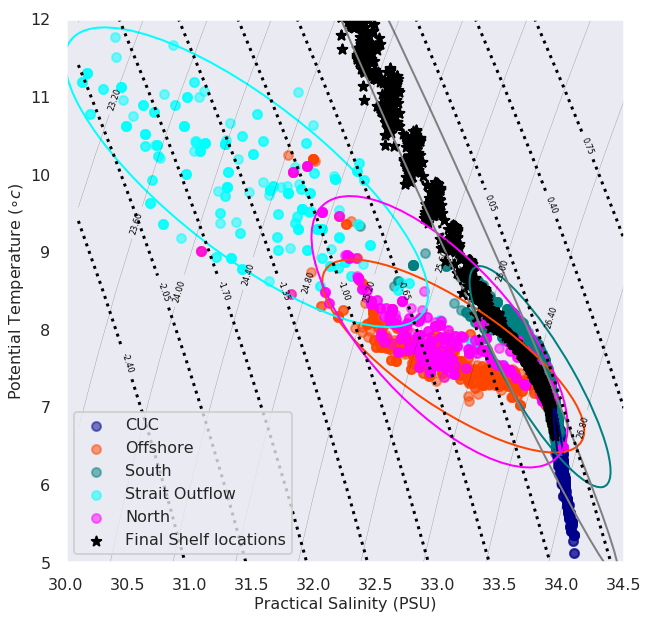

In [ ]:
# colors = cmo.cm.phase(np.linspace(0, 1, 200))


# traj_sal_domain = traj_sal[traj_sal != 1.0100000202412861e+20]
# traj_tem_domain = traj_tem[traj_sal != 1.0100000202412861e+20]

# smin = np.nanmin(traj_sal_last)  - (0.01 * np.nanmin(traj_sal_last))
smin = 30
smax = np.nanmax(traj_sal_last)  + (0.01 * np.nanmax(traj_sal_last))
# tmin = np.nanmin(traj_tem_last) - (0.1 * np.nanmax(traj_tem_last))
tmin = 4
tmax = 12
# tmax = np.nanmax(traj_tem_last) + (0.1 * np.nanmax(traj_tem_last))
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, np.mean(traj_lon), np.mean(traj_lat))

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000;
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = ax.contour(si,ti,dens_1, np.arange(22.4,27,0.4), linestyles='dashed', linewidths = 0.2,colors='k')
CS1 = ax.contour(si,ti,spic_1,np.arange(-2.4,1,0.35), linestyles='dotted', colors='k')
plt.clabel(CS, fontsize=8, inline=1, fmt='%0.2f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.2f') # Label every second level



ax.scatter(traj_sal_final_cuc, traj_tem_final_cuc, s=80, alpha=0.5, c = 'darkblue', label = 'CUC')
sal_mean_cuc = np.mean(traj_sal_final_cuc)
tem_mean_cuc = np.mean(traj_tem_final_cuc)
cov_cuc = np.cov(traj_sal_final_cuc, traj_tem_final_cuc)
cuc_ell = get_cov_ellipse(cov_cuc, (sal_mean_cuc, tem_mean_cuc), 2,
                    ec='darkblue', fc = None)
cuc_ell.set_facecolor('none')
ax.add_artist(cuc_ell)




ax.scatter(traj_sal_final_off, traj_tem_final_off, s=80, alpha=0.5, c = 'orangered', label = 'Offshore')
sal_mean_off = np.mean(traj_sal_final_off)
tem_mean_off = np.mean(traj_tem_final_off)
cov_off = np.cov(traj_sal_final_off, traj_tem_final_off)
off_ell = get_cov_ellipse(cov_off, (sal_mean_off, tem_mean_off), 2,
                    ec='orangered', fc = None)
off_ell.set_facecolor('none')
ax.add_artist(off_ell)


traj_tem_final_north = traj_tem_final_north[traj_sal_final_north > 30]
traj_sal_final_north = traj_sal_final_north[traj_sal_final_north > 30]

ax.scatter(traj_sal_final_south, traj_tem_final_south, s=80, alpha=0.5, c= 'Teal', label = 'South')
sal_mean_south = np.mean(traj_sal_final_south)
tem_mean_south = np.mean(traj_tem_final_south)
cov_south = np.cov(traj_sal_final_south, traj_tem_final_south)
south_ell = get_cov_ellipse(cov_south, (sal_mean_south, tem_mean_south), 3,
                    ec='Teal', fc = None)
south_ell.set_facecolor('none')
ax.add_artist(south_ell)




# traj_tem_final_juan = traj_tem_final_juan[traj_sal_final_juan < 32.8]
# traj_sal_final_juan = traj_sal_final_juan[traj_sal_final_juan < 32.8]

ax.scatter(traj_sal_final_juan, traj_tem_final_juan, s=80, alpha=0.5, c = 'cyan', label = 'Strait Outflow')
sal_mean_juan = np.mean(traj_sal_final_juan)
tem_mean_juan = np.mean(traj_tem_final_juan)
cov_juan = np.cov(traj_sal_final_juan, traj_tem_final_juan)
juan_ell = get_cov_ellipse(cov_juan, (sal_mean_juan, tem_mean_juan), 2,
                    fc = None, ec='cyan')
juan_ell.set_facecolor('none')
ax.add_artist(juan_ell)




ax.scatter(traj_sal_final_north, traj_tem_final_north, s=80, alpha=0.5, c = 'Magenta', label = 'North')
sal_mean_north = np.mean(traj_sal_final_north)
tem_mean_north = np.mean(traj_tem_final_north)
cov_north = np.cov(traj_sal_final_north, traj_tem_final_north)
north_ell = get_cov_ellipse(cov_north, (sal_mean_north, tem_mean_north), 2,
                    ec='Magenta', fc = None)
north_ell.set_facecolor('none')
ax.add_artist(north_ell)


traj_tem_init = traj_tem_init[traj_sal_init > 30]
traj_sal_init = traj_sal_init[traj_sal_init > 30]

ax.scatter(traj_sal_init, traj_tem_init, s=100, marker='*', c = 'k', label = "Final Shelf locations")#'chartreuse')
sal_mean_init = np.mean(traj_sal_init)
tem_mean_init = np.mean(traj_tem_init)
cov_init = np.cov(traj_sal_init, traj_tem_init)
init_ell = get_cov_ellipse(cov_init, (sal_mean_init, tem_mean_init), 2,
                    ec='gray', fc = None)
init_ell.set_facecolor('none')
ax.add_artist(init_ell)


ax.legend(loc = 'best', fontsize = 16)


 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.set_xlim(30,34.5)
ax.set_ylim(5,12)


# legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

In [ ]:
# colors = cmo.cm.phase(np.linspace(0, 1, 200))


# traj_sal_domain = traj_sal[traj_sal != 1.0100000202412861e+20]
# traj_tem_domain = traj_tem[traj_sal != 1.0100000202412861e+20]

# smin = np.nanmin(traj_sal_last)  - (0.01 * np.nanmin(traj_sal_last))
smin = 30
smax = np.nanmax(traj_sal_last)  + (0.01 * np.nanmax(traj_sal_last))
# tmin = np.nanmin(traj_tem_last) - (0.1 * np.nanmax(traj_tem_last))
tmin = 4
tmax = 12
# tmax = np.nanmax(traj_tem_last) + (0.1 * np.nanmax(traj_tem_last))
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, np.mean(traj_lon), np.mean(traj_lat))

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000;
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = ax.contour(si,ti,dens_1, np.arange(22.4,27,0.4), linestyles='dashed', linewidths = 0.2,colors='k')
CS1 = ax.contour(si,ti,spic_1,np.arange(-2.4,1,0.35), linestyles='dotted', colors='k')
plt.clabel(CS, fontsize=8, inline=1, fmt='%0.2f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.2f') # Label every second level



ax.scatter(traj_sal_final_cuc, traj_tem_final_cuc, s=80, alpha=0.5, c = 'darkblue', label = 'CUC')
sal_mean_cuc = np.mean(traj_sal_final_cuc)
tem_mean_cuc = np.mean(traj_tem_final_cuc)
cov_cuc = np.cov(traj_sal_final_cuc, traj_tem_final_cuc)
cuc_ell = get_cov_ellipse(cov_cuc, (sal_mean_cuc, tem_mean_cuc), 2,
                    ec='darkblue', fc = None)
cuc_ell.set_facecolor('none')
ax.add_artist(cuc_ell)




ax.scatter(traj_sal_final_off, traj_tem_final_off, s=80, alpha=0.5, c = 'orangered', label = 'Offshore')
sal_mean_off = np.mean(traj_sal_final_off)
tem_mean_off = np.mean(traj_tem_final_off)
cov_off = np.cov(traj_sal_final_off, traj_tem_final_off)
off_ell = get_cov_ellipse(cov_off, (sal_mean_off, tem_mean_off), 2,
                    ec='orangered', fc = None)
off_ell.set_facecolor('none')
ax.add_artist(off_ell)


traj_tem_final_north = traj_tem_final_north[traj_sal_final_north > 30]
traj_sal_final_north = traj_sal_final_north[traj_sal_final_north > 30]

ax.scatter(traj_sal_final_south, traj_tem_final_south, s=80, alpha=0.5, c= 'Teal', label = 'South')
sal_mean_south = np.mean(traj_sal_final_south)
tem_mean_south = np.mean(traj_tem_final_south)
cov_south = np.cov(traj_sal_final_south, traj_tem_final_south)
south_ell = get_cov_ellipse(cov_south, (sal_mean_south, tem_mean_south), 3,
                    ec='Teal', fc = None)
south_ell.set_facecolor('none')
ax.add_artist(south_ell)




# traj_tem_final_juan = traj_tem_final_juan[traj_sal_final_juan < 32.8]
# traj_sal_final_juan = traj_sal_final_juan[traj_sal_final_juan < 32.8]

ax.scatter(traj_sal_final_juan, traj_tem_final_juan, s=80, alpha=0.5, c = 'cyan', label = 'Strait Outflow')
sal_mean_juan = np.mean(traj_sal_final_juan)
tem_mean_juan = np.mean(traj_tem_final_juan)
cov_juan = np.cov(traj_sal_final_juan, traj_tem_final_juan)
juan_ell = get_cov_ellipse(cov_juan, (sal_mean_juan, tem_mean_juan), 2,
                    fc = None, ec='cyan')
juan_ell.set_facecolor('none')
ax.add_artist(juan_ell)




ax.scatter(traj_sal_final_north, traj_tem_final_north, s=80, alpha=0.5, c = 'Magenta', label = 'North')
sal_mean_north = np.mean(traj_sal_final_north)
tem_mean_north = np.mean(traj_tem_final_north)
cov_north = np.cov(traj_sal_final_north, traj_tem_final_north)
north_ell = get_cov_ellipse(cov_north, (sal_mean_north, tem_mean_north), 2,
                    ec='Magenta', fc = None)
north_ell.set_facecolor('none')
ax.add_artist(north_ell)


traj_tem_init = traj_tem_init[traj_sal_init > 30]
traj_sal_init = traj_sal_init[traj_sal_init > 30]

ax.scatter(traj_sal_init, traj_tem_init, s=100, marker='*', c = 'k', label = "Final Shelf locations")#'chartreuse')
sal_mean_init = np.mean(traj_sal_init)
tem_mean_init = np.mean(traj_tem_init)
cov_init = np.cov(traj_sal_init, traj_tem_init)
init_ell = get_cov_ellipse(cov_init, (sal_mean_init, tem_mean_init), 2,
                    ec='gray', fc = None)
init_ell.set_facecolor('none')
ax.add_artist(init_ell)


ax.legend(loc = 'best', fontsize = 16)


 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.set_xlim(30,34.5)
# ax.set_ylim(5,12)


# legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)